# CS166 Assignment 2 - Traffic Simulation
#### Juan Castro Fernandez

In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

## A general class for simulating traffic in roads with n lanes

In [2]:
class TrafficSimulation:
    def __init__(self, length = 100, density = 0.2, max_vel = 5, p_slowdown = 0.5, p_changelanes = 1, num_lanes = 1, left_bias = 0.5, initial_config = []):
        self.n = length
        self.density = density
        self.max_vel = max_vel
        self.num_lanes = num_lanes
        #bias to change to try to change to the left lane before changing to the right lane (for 3 or more lanes)
        self.left_bias = left_bias
        self.p_slowdown = p_slowdown
        self.p_changelanes = p_changelanes
        #state will be represented as a numpy array of num_lanes x length
        if len(initial_config) == 0:
            self.state = np.array([-1]*num_lanes*length).reshape(num_lanes,length)

            #number of cars according to the density
            num_cars = int(density*num_lanes*length)

            #randomly locating the cars for the initial state
            cars_left = num_cars
            while cars_left:
                i = np.random.randint(0,length)
                j = np.random.randint(0,num_lanes)
                if self.state[j,i] == -1: #if space is empty
                    #initialize cars with velocity 0
                    self.state[j,i] = 0
                    cars_left-=1
        else:
            self.state = initial_config
        
        

    def have_neighbor(self, lane = 0, pos = 0, direction = "left"):
        '''
        This function takes the position of a car and a direction (left or right) as the input parameters
        and returns whether or not there is a neighboring car in that direction. 
        '''
        
        if direction == "left":
            if lane == 0:
                return True #when at the leftmost lane, return True since the position to the left is "blocked"
            else:
                if self.state[lane-1,pos] != -1:
                    return True
                else:
                    return False
        elif direction == "right":
            if lane == self.num_lanes-1:
                return True #when at the rightmost lane, return True since the position to the right is "blocked"
            else:
                if self.state[lane+1,pos] != -1:
                    return True
                else:
                    return False
                
    #looking ahead or behind for the next car (look up to max_vel + 1) and return the gap found
    def look_for_car(self, lane = 0, pos = 0, direction = 1):
        '''
        This function takes a position on the road and a direction (1 = forward or -1 = backward)
        and returns the gap between the given position and the next car in that direction
        if no car is found on the v+1 position then, the returned gap is v+1
        '''
        if lane < 0 or lane >= self.num_lanes: 
            #in case the lane is not within the boundaries, return 0
            return 0
        
        #intialize the gap to 0
        gap = 0
        for d in range(1,self.max_vel+3): #start looking for the cell 1 position ahead and keep increasing the gap until a car is found
            if self.state[lane,int((pos+d*direction)%self.n)] != -1:
                #once you find a car at cell j,i+d or j,i-d, the gap between the position and the car is d-1
                gap = d-1
                break #stop looking for more cars since the fist one was found
            if d == self.max_vel+2:
                #if didn't see any cars in the given horizon, return v+1
                gap = d
        return gap
    
    def criteria_lanes(self,j,i,gaps, direction = 'left'):
        '''
        This function takes as input the position of the car, the direction towards which the car
        will try to change lanes, and dictionary that stores the values of the gaps relevant to 
        satisfy the criteria used on the Rickert-et-al paper. The returned value is a boolean value 
        that is True whenever the criteria is satisfied and False when it is not.
        '''
        #criteria from the paper
        v = int(self.state[j,i])
        l = v+1
        l_0 = v+1 
        l_0back = self.max_vel 
        return gaps["l"] < l and gaps['l_0_'+direction] > l_0 and gaps['l_0back_'+direction] > l_0back and not self.have_neighbor(j,i,direction)
           
    #changing lanes
    def update1(self):
        '''
        This function makes all cars change lanes should they satisfy the criteria to do so. It also
        keeps track of the number of lane changes and returns the number of changes that occured in
        one run of the update lanes step.
        '''
        
        changes = 0
        #empty separate state array
        new_state = np.array([-1]*(self.num_lanes*self.n)).reshape(self.num_lanes,self.n)

        for j in range(self.num_lanes): #for each lane
            for i in range(self.n): #for each position in the lane
                if self.state[j,i] >= 0: #if there is a car in the position
                    #checking gaps and storing in dictionary
                    #l, l_0, and l_0back are defined as in the Ricker et al paper
                    #I keep track of both the gaps of the right and left lane
                    gaps = {'l':self.look_for_car(j,i,1),
                            'l_0_left':self.look_for_car(j-1,i,1),
                            'l_0_right':self.look_for_car(j+1,i,1),
                            'l_0back_left':self.look_for_car(j-1,i,-1),
                            'l_0back_right':self.look_for_car(j+1,i,-1)}
                    
                    #randomly choose the lane towards which you want to try to move first
                    #accounting for the bias to try left first, the default value is 0.5
                    if np.random.random() <= self.left_bias:
                        checkfirst = 'left'
                        checksecond = 'right'
                    else:
                        checkfirst = 'right'
                        checksecond = 'left'
                    
                    if self.criteria_lanes(j,i,gaps,checkfirst): #if criteria for changing towards desired direction
                        if np.random.random() <= self.p_changelanes: 
                            #change lanes and record the change in the new state
                            new_state[j-1,i], new_state[j,i] = self.state[j,i], -1
                            #add one to the change of lanes counter
                            changes+=1
                        else:
                            if not self.criteria_lanes(j,i,gaps,checksecond):
                            #stay in the same lane and record it in the new state
                                new_state[j,i] = self.state[j,i]
                            
                    #if criteria was not satisfied for the first lane tried, try the other direction
                    else:
                        if self.criteria_lanes(j,i,gaps,checksecond):
                            if np.random.random() <= self.p_changelanes:
                                new_state[(j+1)%self.num_lanes,i], new_state[j,i] = self.state[j,i], -1
                                #add one to the change of lanes counter
                                changes+=1
                            else:
                                new_state[j,i] = self.state[j,i]
                        else:
                            new_state[j,i] = self.state[j,i]
                            
        #update the current state
        self.state =  new_state
        return changes #return the total number of changes
    
    def update1_async(self):
        '''
        This function does the same as update1, but the update happens asynchronously to prevent two
        different cars to switch into the same position (when we have more than 2 lanes)
        '''
        changes = 0
        #empty separate state array

        for j in range(self.num_lanes): #for each lane
            for i in range(self.n): #for each position in the lane
                if self.state[j,i] >= 0: #if there is a car in the position
                    #checking gaps and storing in dictionary
                    #l, l_0, and l_0back are defined as in the Ricker et al paper
                    #I keep track of both the gaps of the right and left lane
                    gaps = {'l':self.look_for_car(j,i,1),
                            'l_0_left':self.look_for_car(j-1,i,1),
                            'l_0_right':self.look_for_car(j+1,i,1),
                            'l_0back_left':self.look_for_car(j-1,i,-1),
                            'l_0back_right':self.look_for_car(j+1,i,-1)}
                    
                    #randomly choose the lane towards which you want to try to move first
                    #accounting for the bias to try left first, the default value is 0.5
                    if np.random.random() <= self.left_bias:
                        checkfirst = 'left'
                        checksecond = 'right'
                    else:
                        checkfirst = 'right'
                        checksecond = 'left'
                    
                    check_other = True
                    if self.criteria_lanes(j,i,gaps,checkfirst): #if criteria for changing towards desired direction
                        if np.random.random() <= self.p_changelanes: 
                            #change lanes and record the change in the new state
                            if checkfirst == "left":
                                self.state[j-1,i], self.state[j,i] = self.state[j,i], -1
                            else:
                                self.state[(j+1)%self.num_lanes,i], self.state[j,i] = self.state[j,i], -1
                            #add one to the change of lanes counter
                            changes+=1
                            check_other = False
                            
                    #if criteria was not satisfied for the first lane tried, try the other direction
                    elif check_other:
                        if self.criteria_lanes(j,i,gaps,checksecond):
                            if np.random.random() <= self.p_changelanes:
                                if checksecond == "left":
                                    self.state[j-1,i], self.state[j,i] = self.state[j,i], -1
                                else:
                                    self.state[(j+1)%self.num_lanes,i], self.state[j,i] = self.state[j,i], -1
                                #add one to the change of lanes counter
                                changes+=1

        return changes #return the total number of changes     
        
    def update2(self):
        '''
        This function makes all cars update their velocities according to the single-lane conditions.
        It also keeps track of all the flows in a given run of the update step and returns the space-averaged
        flow rate of that single run
        '''
            
        #keep track of the number of flows between n-1 and 0 for this simulation step
        flows = 0
        
        #move cars
        new_state = np.array([-1]*(self.num_lanes*self.n)).reshape(self.num_lanes,self.n)
        for j in range(self.num_lanes): #for each lane
            for i in range(self.n): 
                if self.state[j,i] >= 0:
                    if i+self.state[j,i] >= self.n:
                        flows+=1
                    new_state[j,int((i+self.state[j,i])%self.n)]=self.state[j,i]
        self.state = new_state
        
        
        #updating velocities
        for j in range(self.num_lanes):
            for i in range(self.n):
                if self.state[j,i] >= 0:
                    #variable of the new vel that contains copy of current velocity that will be updated by rules 1-4
                    new_vel = self.state[j,i]

                    #rule 1 (I only check for the distance between the current and next car in rule 2)
                    if self.state[j,i] < self.max_vel:
                        new_vel+=1

                    #rule 2
                    #check distance
                    distance = self.max_vel # assume there's enough space to go at max_vel 
                    for d in range(1,self.max_vel+1): #check for all cells between the next and the one at distance max_vel
                        if self.state[j,int((i+d)%self.n)] != -1:
                        #if car is found d steps ahead, update distance to d-1
                            distance = d-1
                            #break the loop because you don't care about the next potential cars ahead
                            break
                    if new_vel > distance:
                        #slowdown to make sure you don't crash (if necessary)
                        new_vel = distance

                    #rule 3
                    if new_vel >= 1:
                        if np.random.random() < self.p_slowdown:
                            #randomly slowing down
                            new_vel -=1

                    #update velocity of car
                    self.state[j,i] = new_vel 
                
        return flows/self.num_lanes #return the number of flows in the update step (this value is 0, 1, or 2)
    
    #putting both updates together
    def update(self):
        c = self.update1()
        f = self.update2()
        return (f,c)
    
    #same as update but with asynchronous lane updates
    def update_async(self):
        c = self.update1_async()
        f = self.update2()
        return (f,c)

    #display with dots and numbers
    def display(self):
        for j in range(self.num_lanes):
            print(''.join('.' if x==-1 else str(int(x)) for x in self.state[j,:]))                
    
    #display with heatmap
    def heatmap_display(self):
        plt.figure(figsize=(20,.5+(.5*self.num_lanes)))
        sns.heatmap(np.where(self.state==-1, np.nan, self.state),
                    square=True,cmap="RdYlGn", vmin=0, vmax=5, 
                    cbar=False, xticklabels=False, yticklabels=False,
                    linewidths=1, linecolor='black', alpha=.7)

## Functions to measure flow and plot results

In [3]:
def get_q(sim, n_sims =20, timesteps = 200, t_0 = 100, async_update = False):
    '''
    Given a TrafficSimulation object, a number of simulations, a number of undocumented timesteps (t0),
    a number of timesteps for which data will be collected, and whether or not the lane updates will be
    done asynchronously, the function returns the recorded flows their mean, their 95% confidence interval
    and the simulated-averaged lane changes rate.
    '''
    #list keep track of flows for each simulation
    flows = []
    #list keep track of lane changes for each simulation
    lane_changes = []
    for i in range(n_sims):
        flow_counter = 0
        lane_change_counter = 0
        #simulate without collecting data for the first t_0 timesteps (implemented in the Nagel, K.
        #and Schreckenberg, M. paper
        for _ in range(t_0):
            
            if async_update:
                sim.update_async() #asynchronous updating
            else:
                sim.update() #synchronous updating
        
        #after t_0 timesteps, start collecting the data for the number of timesteps specified
        for t in range(timesteps):
            if async_update:
                #asynchronous
                f,c = sim.update_async() 
            else:
                #synchronous
                f,c = sim.update() #f is the number of flows, c is the number of lane_changes
            flow_counter+=f #add the number of flows per update in each timestep
            lane_change_counter+=c #add the number of lane changes per update in each timestep
        flows.append(flow_counter/timesteps) #add time-averaged flow
        lane_changes.append(lane_change_counter/timesteps) #add time-averaged lane changes rate
    
    #calculate mean, standard deviation and 95% confidence interval of the time-averaged flows across simulations
    mu = np.mean(flows)
    std = np.std(flows)
    confint = [np.percentile(flows,2.5),np.percentile(flows,97.5)]
    
    averaged_changes = np.mean(lane_changes)
        
    return (mu,confint,flows,averaged_changes)

In [12]:
def collect_data(n_sims = 20, density_linspace_size = 40, density_linspace_range = (0,0.8), tsteps_per_sim = 200, p_slowdown=0.5, num_lanes = 1, t_0 = 100, road_length = 100, async_update = False, densities_skewed_left = False):
    '''
    This function takes number of simulations per density, number of densities, range for the density linspace,
    number of timesteps per simulation, probability of slowing down and number of lanes for the initialization 
    of a TrafficSimulation object, number of "warmup" timesteps, and whether or not the lane changes update step
    should be done asynchronously (should be True for 3 or more lanes) and returns a dictionary that contains all 
    the datapoints for each simulation, the means per denisity witht the confidence intervals, the density linspace, 
    the density expanded linspace to be able to easily plot all the datapoints for each density, and the lane change
    rate average per density
    '''
    n_sims = n_sims #number of simulations per density (dots in the scatter plot per density value)
    N = density_linspace_size #number of densities that will be checked between 0 and 0.8
    
    flow_avg = np.zeros(N) #simulation-averaged q_values per density value
    confints = [] #confidence intervals for the simulation-averaged q_values per density value
    flow_datapoints = [] #q-values for each simulation per density value (this will be a nested list)
    lane_changes_avg = np.zeros(N)
    
    lower = density_linspace_range[0]
    upper = density_linspace_range[1]
    if densities_skewed_left:
        t = np.append(np.linspace(lower,0.2,int(density_linspace_size/2)),np.linspace(0.2,upper,int(density_linspace_size/2)))
    else:
        t = np.linspace(lower,upper,N) #density linspace
    tdatapoints = np.array([np.array([x]*n_sims) for x in t]).reshape(-1) #density linspace expanded for plotting all flow_datapoints
    
    for i in range(N):
        #initializing a TrafficSimulation object
        sim = TrafficSimulation(length = road_length,p_slowdown = p_slowdown, density=t[i], num_lanes = num_lanes)
        #obtaining output from the get_q function
        avg, confint, scattered, avg_changes = get_q(sim, n_sims =n_sims, timesteps =tsteps_per_sim, t_0=t_0, async_update = async_update)
        #storing the output values
        flow_avg[i] = avg
        lane_changes_avg[i] = avg_changes
        confints.append(confint)
        flow_datapoints.append(scattered)
        
    #return results in the form of a dictionary
    return {'flow_avg' : flow_avg, 
            'confints': np.array(confints), 
            'flow_datapoints' : np.array(flow_datapoints),
            'densities': t,
            'densities_datapoints': tdatapoints,
            'lane_changes':lane_changes_avg}

In [13]:
def plot_data(data, dots = True, color ="black", title = "Simulation", xlim = [],ylim = []): #dictionary data must be passed
    '''
    This function plots the data that the collect_data function yields as output
    '''
    plt.figure(figsize=(10,10))
    tscattered = data['densities_datapoints']
    flows = data['flow_datapoints'].reshape(-1)
    t = data['densities']
    flow_avg = data['flow_avg']
    confints = data['confints']
    
    #scatter plot
    if dots:
        plt.scatter(tscattered,flows, color =color, s=3,alpha=0.8)
    #mean plot
    plt.plot(t,flow_avg, color = color,alpha =0.8)
    #confints plot
    for j in range(len(confints)):
        plt.plot([t[j],t[j]],confints[j], color = color,alpha = 0.5,linewidth=1)
        plt.scatter([t[j],t[j]],confints[j], color = color, marker = "_", s=80)
    plt.fill_between(t,confints[:,0], confints[:,1], color = color,alpha=0.15)
    
    #styling the graph
    plt.ylabel('flow [cars per time step]',labelpad=10)
    plt.xlabel('density [cars per site]',labelpad=10)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title(title,pad=15)
    plt.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Courier New"
    plt.rcParams["font.size"] = "20"
    plt.show()

In [134]:
def plot_multiple(datalist,labels = None,intervals = True, xlim = [], ylim = []): #dictionary data must be passed
    '''
    This function plots the data that a list of dictionaries outputed by the collect_data function 
    in the same plot for comparison. Labels for each data can be provided and confidence intervals
    can be plotted or not (choose False when comparing several models so that plot does not look 
    convoluted, otherwise leave it as True - optimal for comparing two models at a time)
    '''
    plt.figure(figsize=(12,10))
    
    colormap = ['black','red','green','blue','purple']
    for i in range(len(datalist)):
        data = datalist[i]
        if labels:
            lbl = labels[i]
        else:
            lbl = ''
        tscattered = data['densities_datapoints']
        flows = data['flow_datapoints']
        t = data['densities']
        flow_avg = data['flow_avg']
        confints = data['confints']

        #scatter plot
        plt.plot(t,flow_avg, color =colormap[i],alpha =1,label = lbl)
        if intervals:
            plt.fill_between(t,confints[:,0], confints[:,1], color = colormap[i],alpha=0.08)
            
    plt.ylabel('flow [cars per time step]',labelpad=10)
    plt.xlabel('density [cars per site]',labelpad=10)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title('Model comparison',pad=15)
    plt.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Courier New"
    plt.rcParams["font.size"] = "20"
    plt.legend()
    plt.show()

## Part 1: Traffic jams on a circular road

......4.................4...............................5...
.5........4.................5...............................
......4.......4..................4..........................
..........4.......5..................5......................
..............5........5..................4.................
...................4........5.................5.............
.......................5.........4.................4........
............................4........4.................4....
................................5........4.................5
....5................................4.......4..............
.........4...............................4.......4..........
.............4...............................5.......5......
.................5................................4.......4.
..5...................4...............................4.....
.......4..................4...............................5.
...4.......4..................5.............................
.......4.......5........

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:281: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


............................4.......5.....................5.
...4............................4........5..................
.......5............................4.........5.............
............5...........................4..........4........


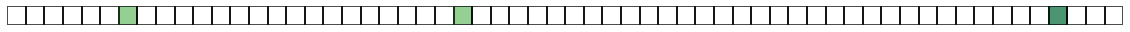

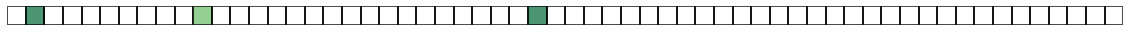

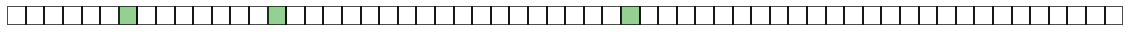

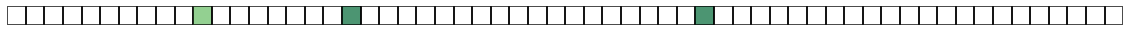

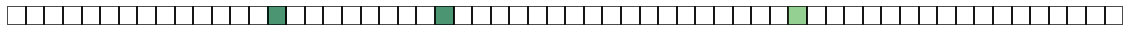

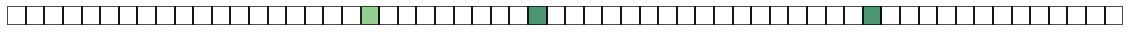

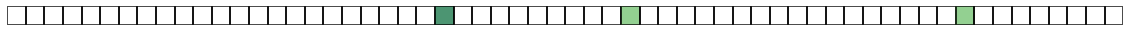

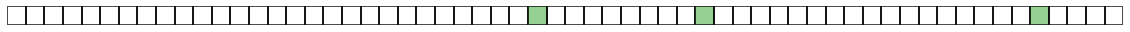

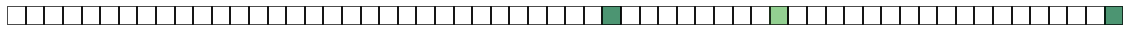

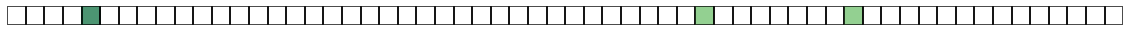

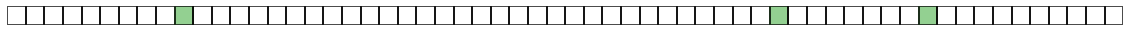

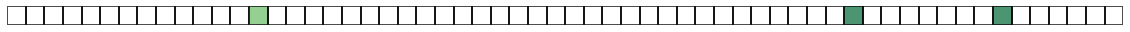

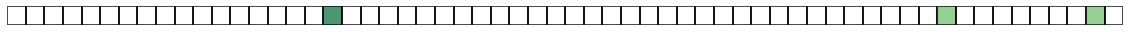

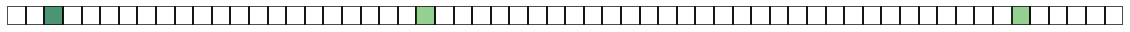

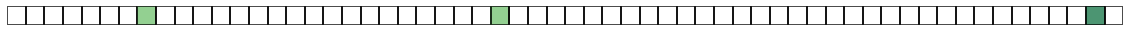

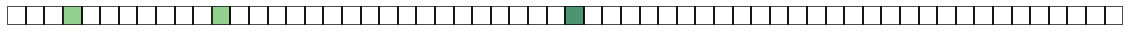

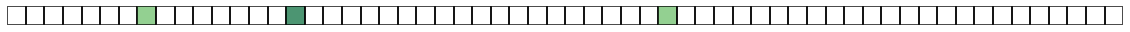

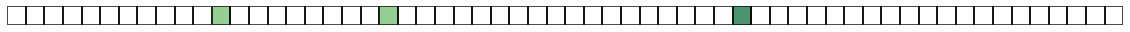

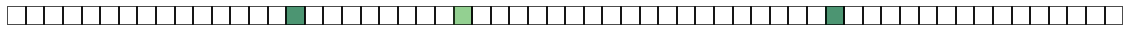

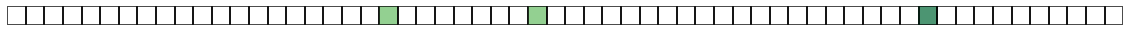

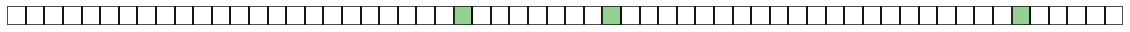

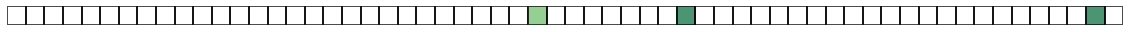

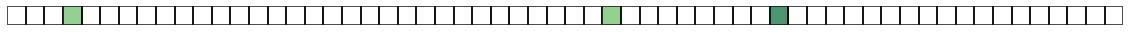

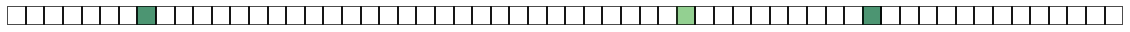

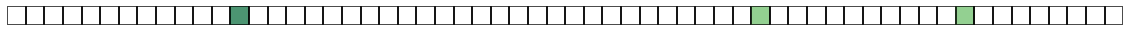

In [7]:
single1 = TrafficSimulation(length = 60,num_lanes=1,density = 0.05)
for i in range(200):
    single1.update()
for i in range(25):
    single1.update()
    single1.display()
    single1.heatmap_display()

...4....5.............4............4......001...000..1.2....
.......5.....5............5............1..00.1..000...1..2..
............4.....5............4........1.01..0.000....1...2
.3..............4......4...........4.....01.1.1.001.....2...
....3...............5......4...........0.1.1.0.001.1......3.
.3.....3.................4.....5.......1..1.00.01.0.2.......
....3.....3..................4......3...2..000.1.01...2.....
.......3.....3...................4.....1..0001..00.2....2...
..........4.....4....................2..1.000.1.01...3....2.
3.............5.....5..................1.0001..00.2.....3...
...3...............4.....5..............0000.0.00...3......3
..2...3................5......4.........0000.0.00......3....
....2....4..................4.....5.....0000.0.00.........4.
..2...2......5..................4......00000.0.00...........
....2...2.........4.................1..00001.1.00...........
......2...3...........4..............0.0001.1.001...........
........2....3..........

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:281: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


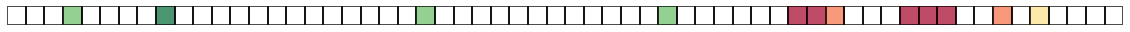

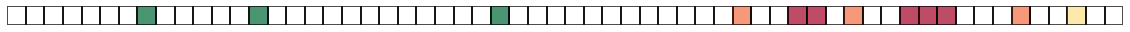

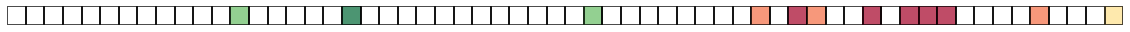

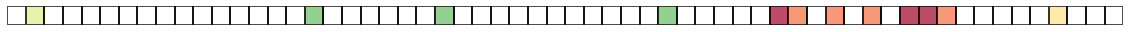

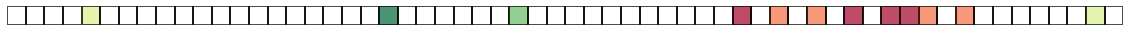

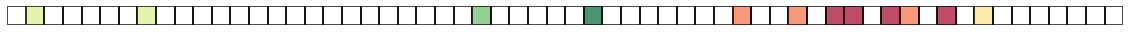

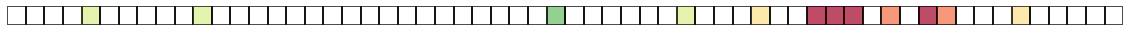

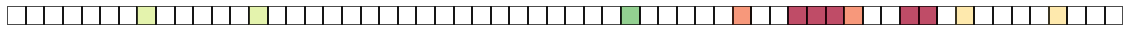

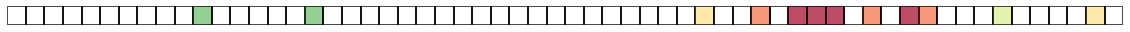

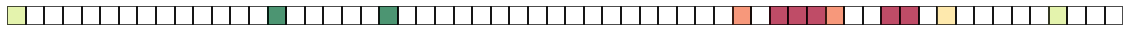

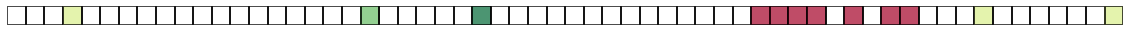

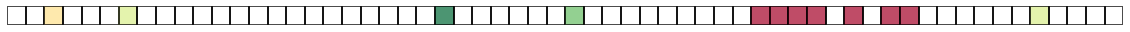

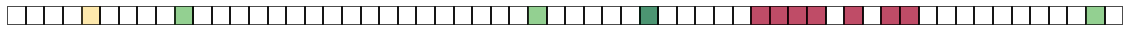

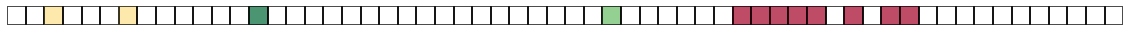

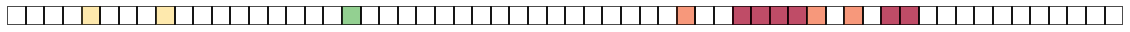

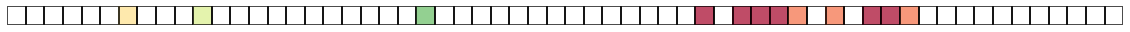

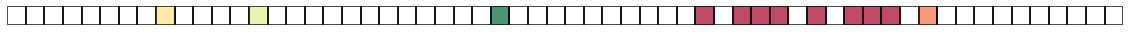

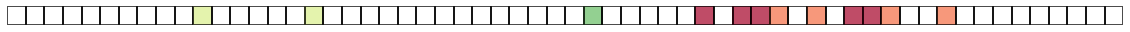

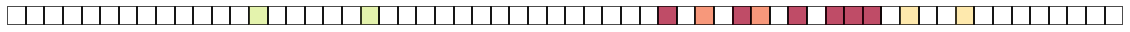

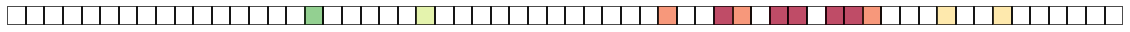

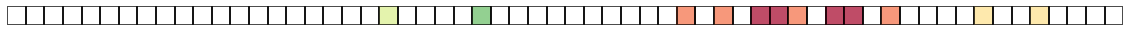

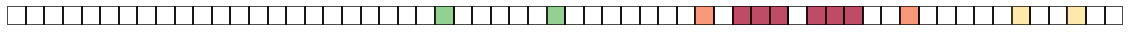

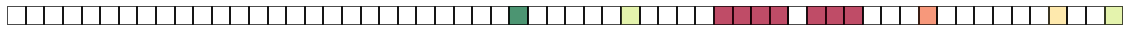

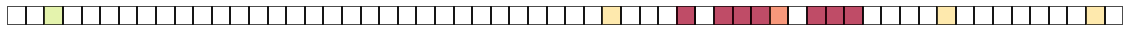

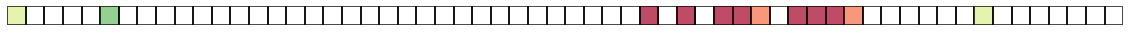

In [9]:
single2 = TrafficSimulation(length = 60,num_lanes=1,density = 0.2)
for i in range(200):
    single2.update()
for i in range(25):
    single2.update()
    single2.display()
    single2.heatmap_display()

## Traffic flow variation over various densities

In [109]:
data1 = collect_data(25,40,(0,0.8),200,0.5,1,100)

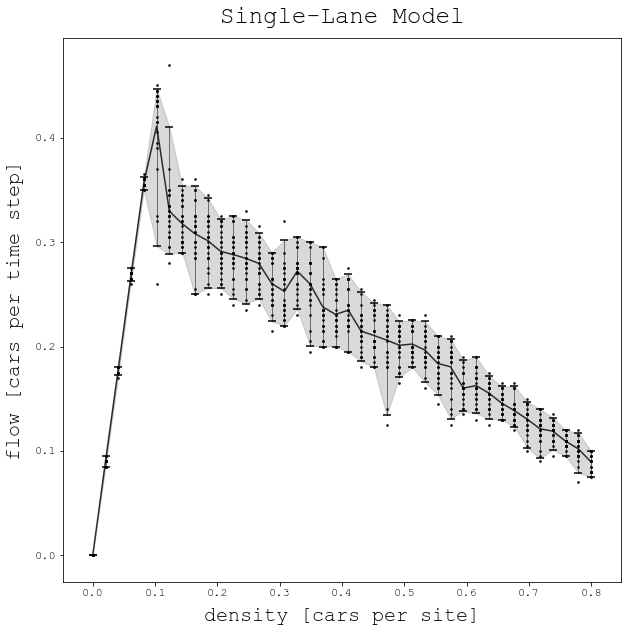

In [110]:
plot_data(data1, title = "Single-Lane Model")

## Part 2: Multi-lane highways

............5...............................5........4...........
...............................5......5........5.................
.................4...............................4.......5.......
....................................4......4........5............
.....................4...............................5........5..
........................................5......5.........4.......
..5......................4................................5......
.............................................5......4........5...
.......4.....................4.................................5.
.4................................................5.....4........
...4.......4.....................5.....................5.........
.....4......................................................4....
.......4.......5......................4.....................4....
.........4......................................................4
...........4........4.....................4.....................5
...4......

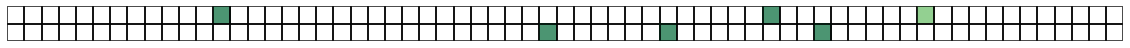

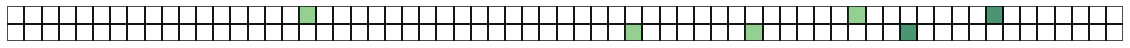

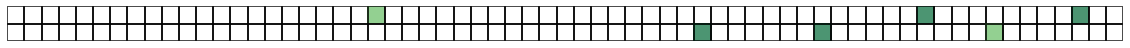

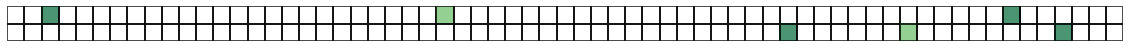

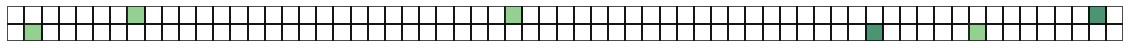

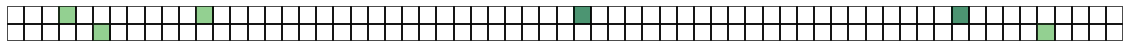

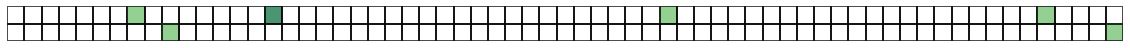

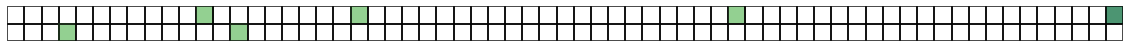

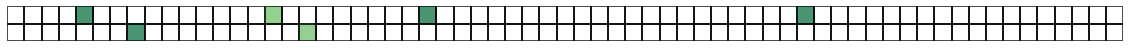

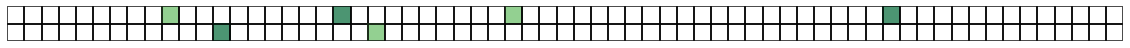

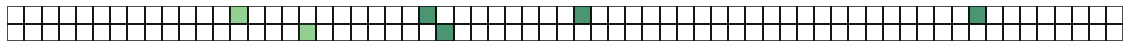

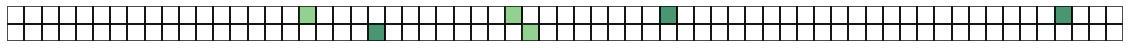

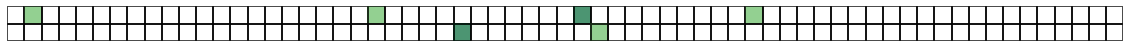

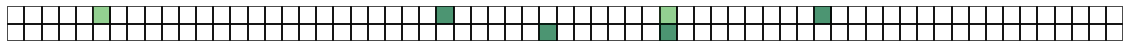

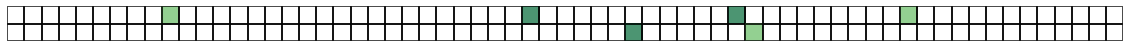

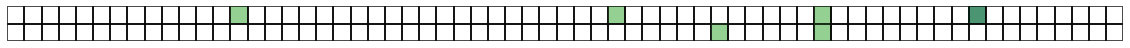

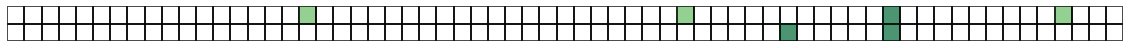

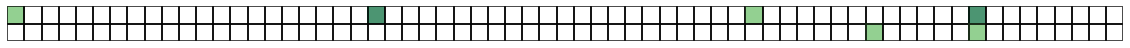

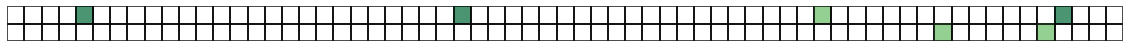

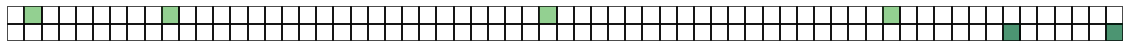

In [146]:
double1 = TrafficSimulation(length = 65,num_lanes=2,density = 0.05)
for i in range(200):
    double1.update()
for i in range(20):
    double1.update()
    double1.display()
    double1.heatmap_display()

....2......4......4......5.........1....2...000..2......2........
.....3.............4.........2...00...2..1.1.000....1.0.2.....2..
......3........5......5.......5.....2.....0.001....2......2......
........3..............4.......1.01.....1.0.0001.....01...3.....2
.........4..........4......5.......2..3...1.01.2.....3......2....
.3.........4...............4....00.2.....01.000.1....1.2.....3...
.............4..........5.......4....3...0.01.1..2......3.....2..
....4..........5...............000...2...1.0001..1....1..2......3
.................4...........5......3...00.0.1.2...2.......4....2
..4.....4...........5..........001.....2..0000.2..1....2...3.....
.2...................5............4....001.1..1..2...3.........1.
......5.....4............5.....01.2......00000...1.1.....3....3..
...3......................4....0......000.1.2..2...3....3.......1
3..........4....5.............1..2..2....00000....1.1.......3....
2.....4........5..............01......000..2..2..3....4....4.....
...3......

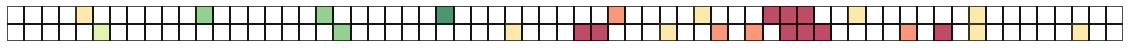

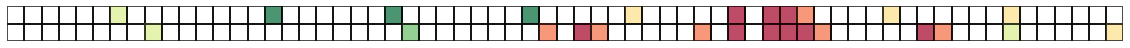

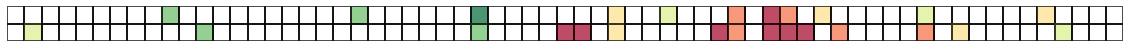

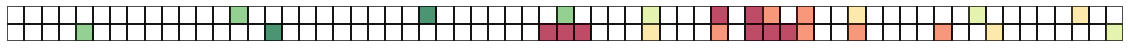

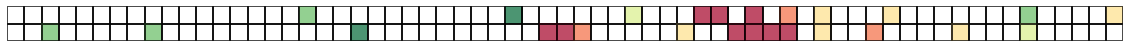

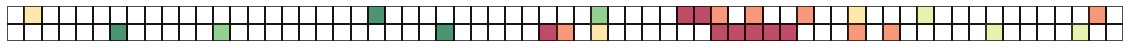

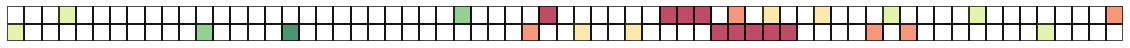

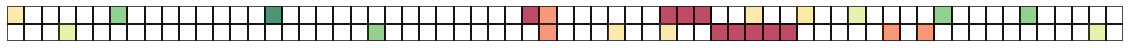

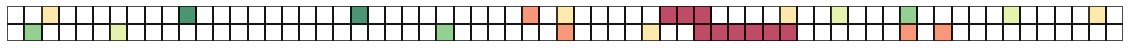

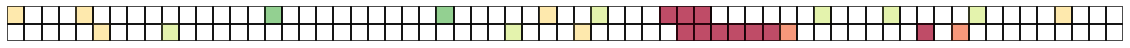

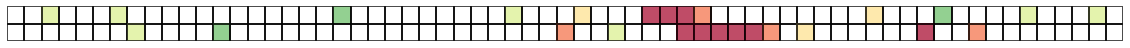

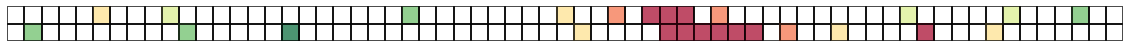

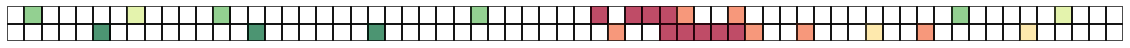

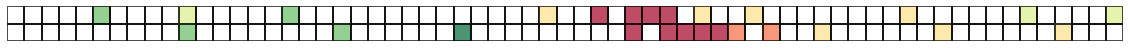

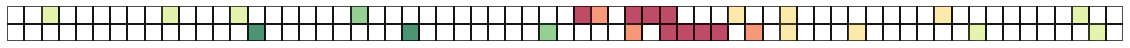

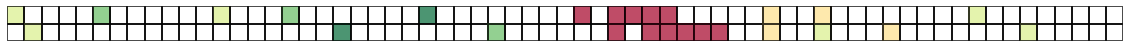

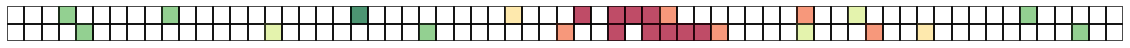

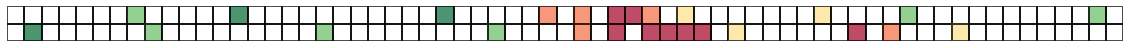

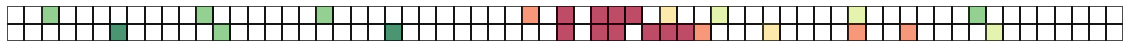

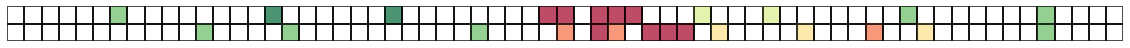

In [150]:
double2 = TrafficSimulation(length = 65,num_lanes=2,density = 0.2)
for i in range(200):
    double2.update()
for i in range(20):
    double2.update()
    double2.display()
    double2.heatmap_display()

In [112]:
data2 = collect_data(25,40,(0,0.8),200,0.5,2,100)

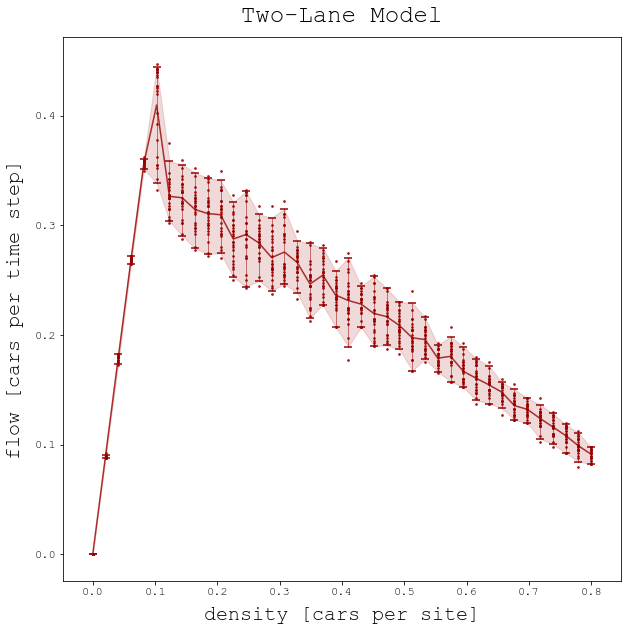

In [113]:
plot_data(data2, title = "Two-Lane Model", color = "#990000")

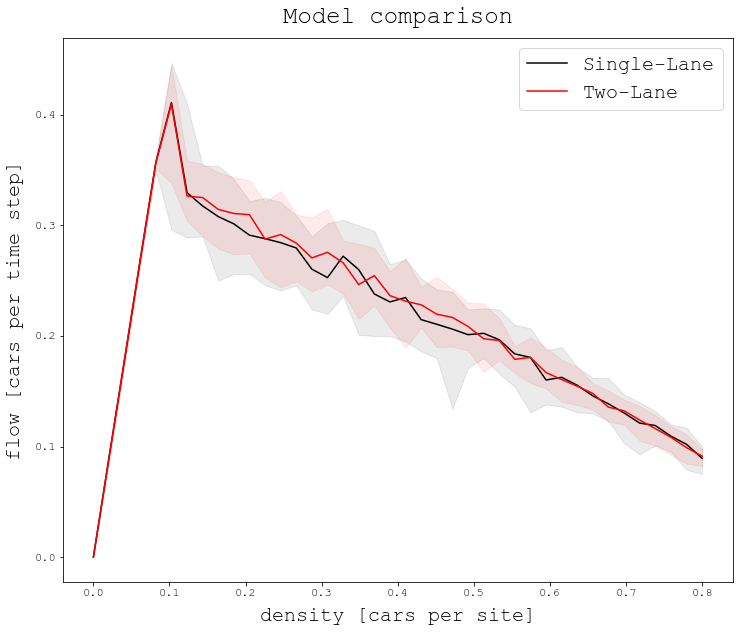

In [133]:
plot_multiple([data1,data2], ["Single-Lane","Two-Lane"])

In [114]:
data3 =  collect_data(25,40,(0,0.8),200,0.5,3,100,async_update=True)

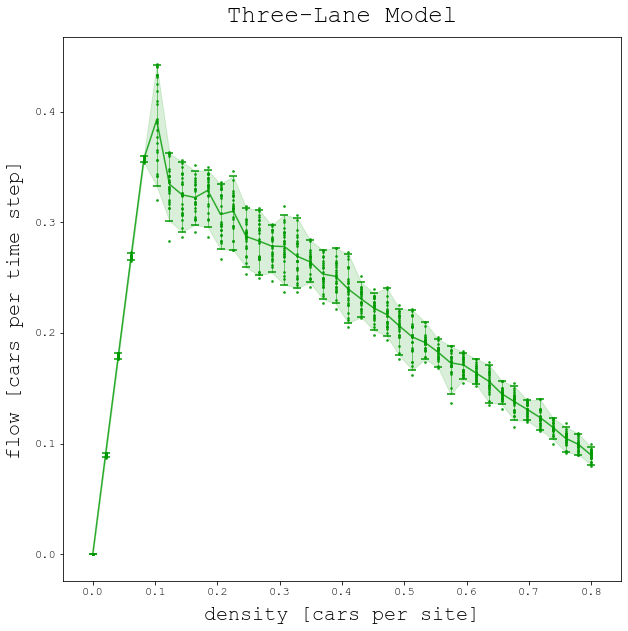

In [115]:
plot_data(data3, title = "Three-Lane Model", color="#009900")

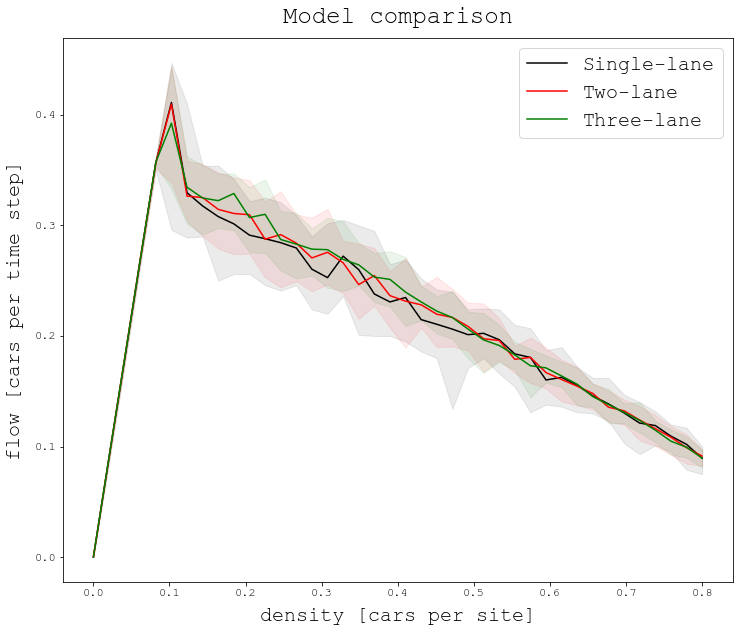

In [136]:
plot_multiple([data1,data2,data3],["Single-lane","Two-lane","Three-lane"])

In [139]:
data11 = collect_data(25,14,(0,0.5),200,0.5,1,400,100,True,True)

In [141]:
data22 = collect_data(25,14,(0,0.5),200,0.5,2,400,100,True,True)

In [151]:
data33 = collect_data(25,14,(0,0.5),200,0.5,3,400,100,True,True)

In [153]:
data44 = collect_data(25,14,(0,0.5),200,0.5,4,400,100,True,True)

In [ ]:
data55 = collect_data(25,14,(0,0.5),200,0.5,5,400,100,True,True)

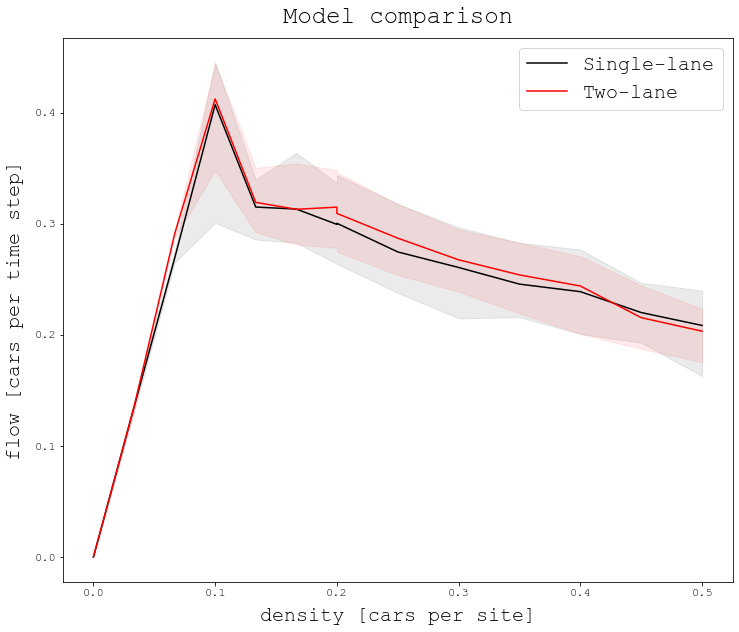

In [142]:
plot_multiple([data11,data22],["Single-lane","Two-lane"])

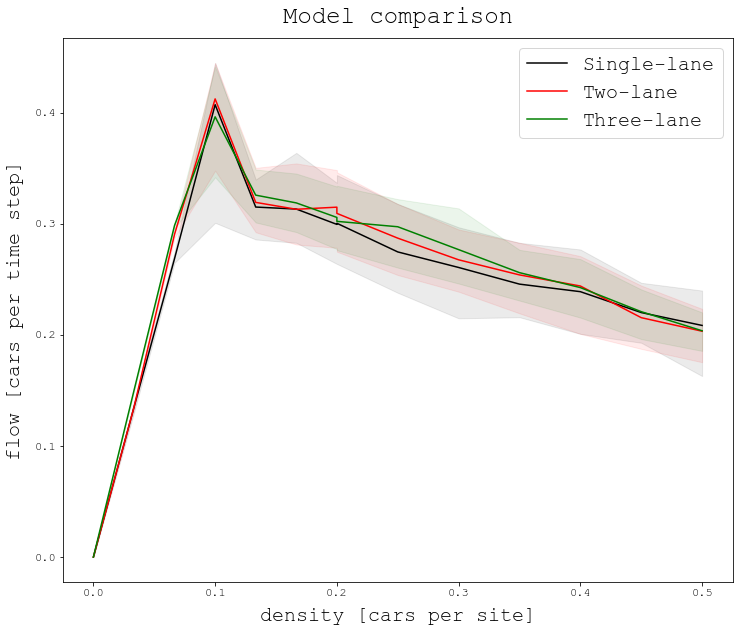

In [152]:
plot_multiple([data11,data22,data33],["Single-lane","Two-lane","Three-lane"])

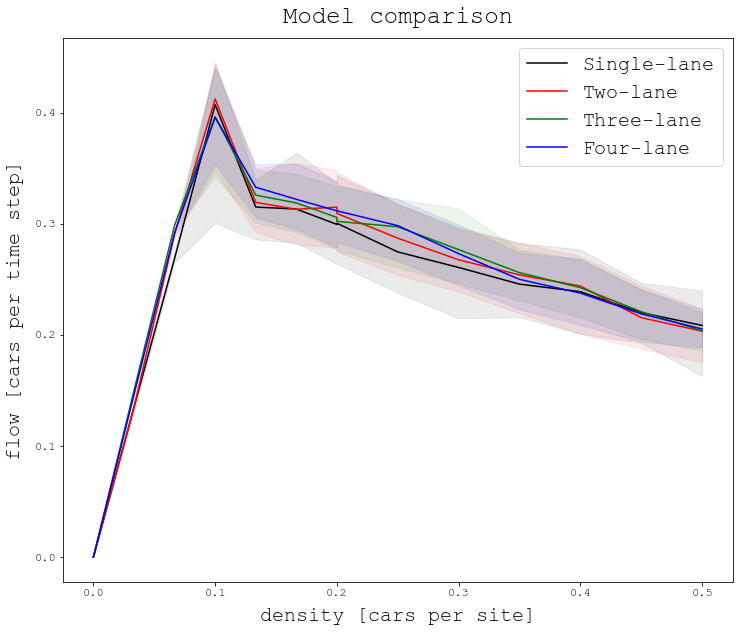

In [154]:
plot_multiple([data11,data22,data33,data44],["Single-lane","Two-lane","Three-lane","Four-lane"])

In [122]:
data4 =  collect_data(25,20,(0,0.8),200,0.5,4,400,100,True,True)

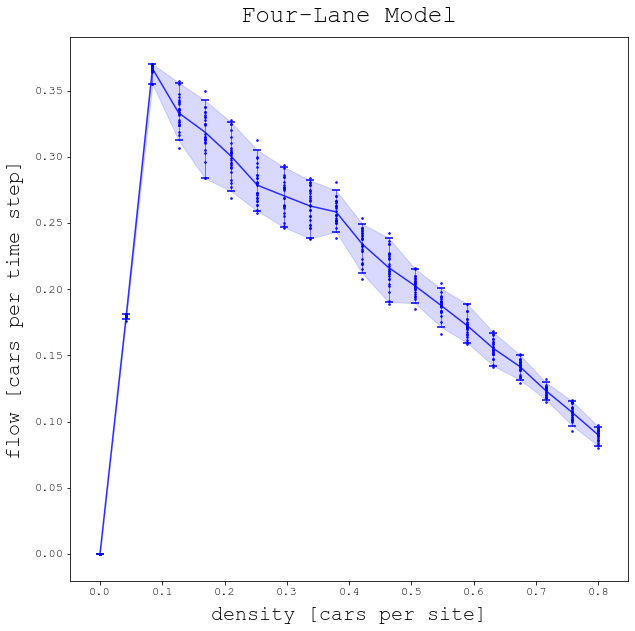

In [123]:
plot_data(data4, title = "Four-Lane Model", color="blue")

In [124]:
data5 =  collect_data(25,20,(0,0.8),200,0.5,5,100,async_update=True)

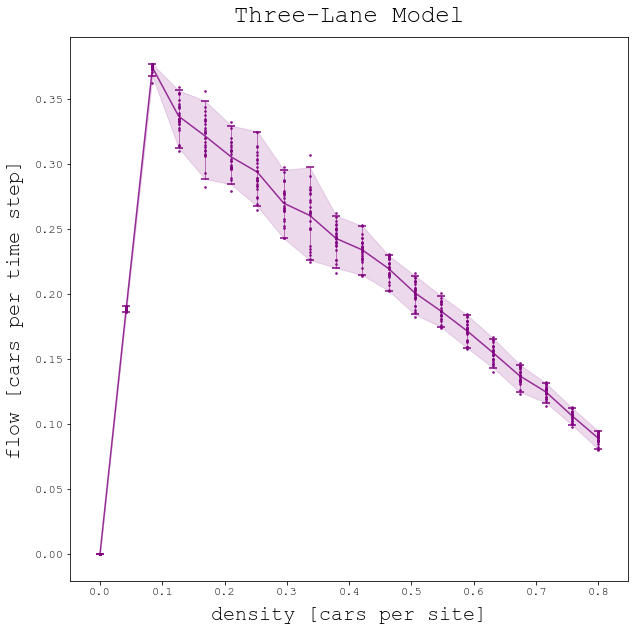

In [125]:
plot_data(data5, title = "Three-Lane Model", color="purple")

In [ ]:
data10 =  collect_data(25,20,(0,0.8),200,0.5,10,100,async_update=True)

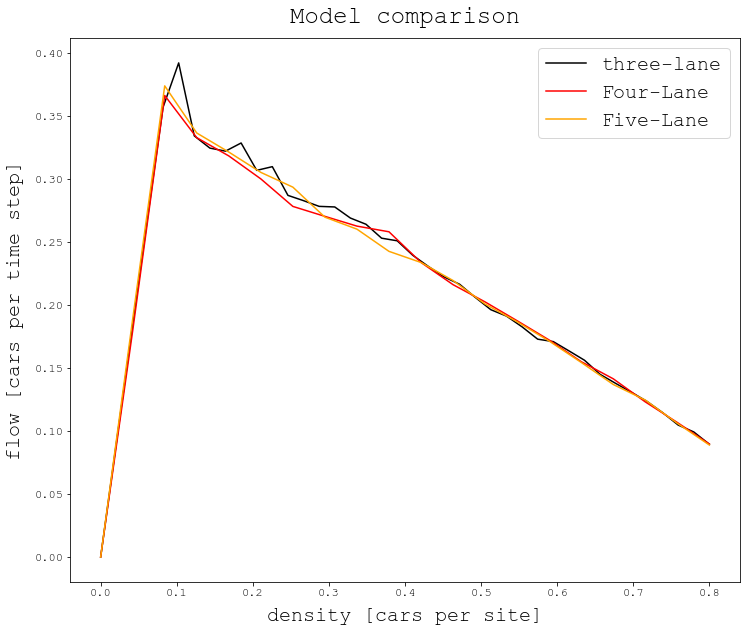

In [131]:
plot_multiple([data3,data4,data5],labels = ["three-lane","Four-Lane","Five-Lane"], intervals = False)

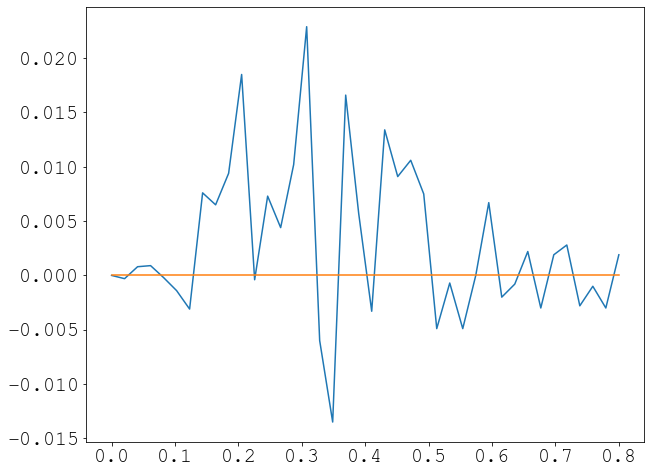

In [121]:
plt.figure(figsize=(10,8))
plt.plot(data1['densities'],data2['flow_avg']-data1['flow_avg'])
plt.plot(data1['densities'],[0]*len(data1['densities']))
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data3['densities'],data3['lane_changes'])
plt.show()

In [ ]:
plot_multiple([data1,data2],labels = ["Single-Lane","Two-Lane"], intervals = False,xlim=[0.01,0.45])

In [23]:
#replicating Figure 3 (Symmetric Two-Lane Road) from Rickert-et-al
replicate2 = collect_data(50,50,(0,0.5),200,0.5,1,50,100)

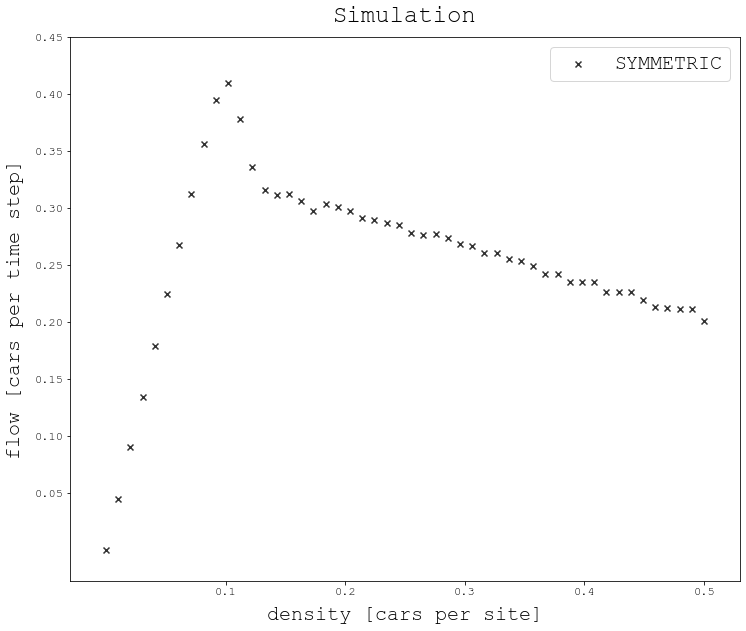

In [24]:
plt.figure(figsize=(12,10))

t = replicate2['densities']
flow_avg = replicate2['flow_avg']

plt.scatter(t,flow_avg, color = "black",alpha =0.8,marker ="x", label = "SYMMETRIC")

plt.yticks([.05,.1,.15,.2,.25,.3,.35,.4,.45])
plt.xticks([0.1,.2,.3,.4,.5])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('density [cars per site]',labelpad=10)
plt.title('Simulation',pad=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "20"
plt.legend()
plt.show()

In [63]:
#replicating Figure 4 (Single vs. Symmetric Two-Lane Road) from Rickert-et-al
rep1 = collect_data(25,11,(0.05,0.15),400,0.5,1,250,200)

In [64]:
rep2 = collect_data(25,11,(0.05,0.15),400,0.5,2,250,200)

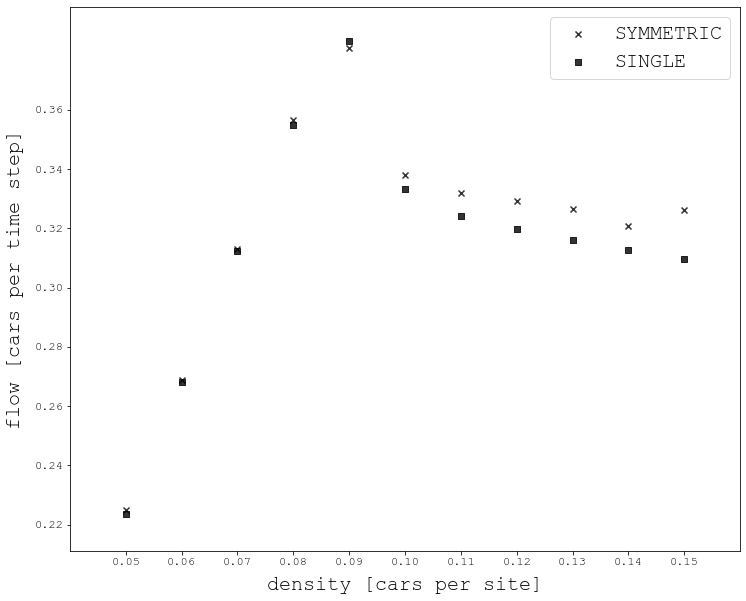

In [65]:
plt.figure(figsize=(12,10))

t1 = rep1['densities']
flow_avg1 = rep1['flow_avg']

t2 = rep2['densities']
flow_avg2 = rep2['flow_avg']

plt.scatter(t2,flow_avg2, color = "black",alpha =0.8,marker ="x", label = "SYMMETRIC")
plt.scatter(t1,flow_avg1, color = "black",alpha =0.8,marker ="s", label = "SINGLE")

#     plt.plot(t,confints[:,1], color = "green")
plt.yticks([.22,.24,.26,.28,.3,.32,.34,.36])
plt.xticks([0.05,.06,.07,.08,.09,.1,.11,.12,.13,.14,.15])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('density [cars per site]',labelpad=10)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "20"
plt.legend()
plt.show()

In [50]:
data1det = collect_data(20,40,(0,0.8),200,0,1,200)

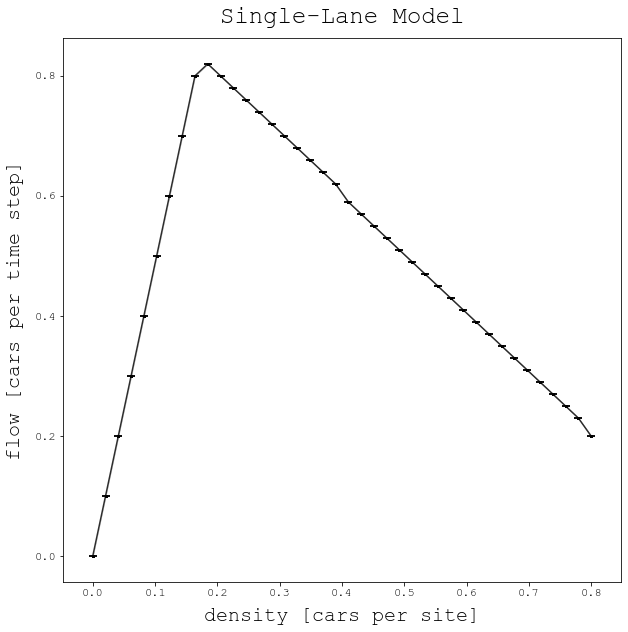

In [51]:
plot_data(data1det, title = "Single-Lane Model")

In [52]:
data2det = collect_data(20,40,(0,0.8),200,0,2,200)

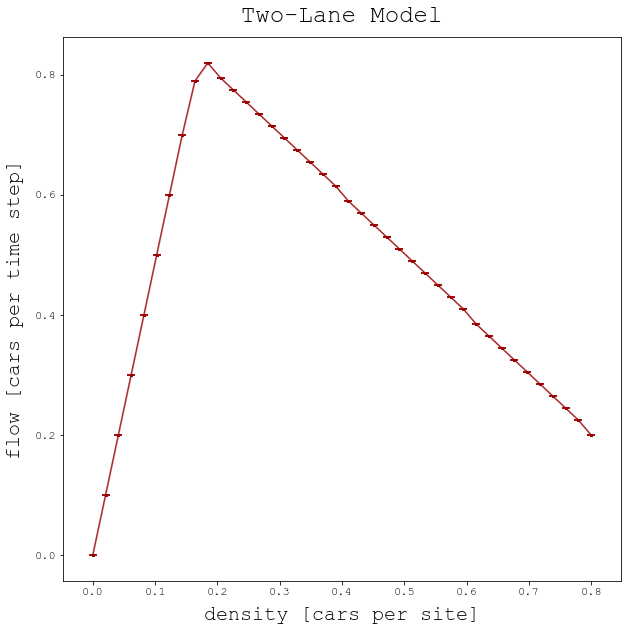

In [53]:
plot_data(data2det, title = "Two-Lane Model", color = "#990000")

In [54]:
data3det =  collect_data(20,40,(0,0.8),200,0,3,200,100,async_update=True)

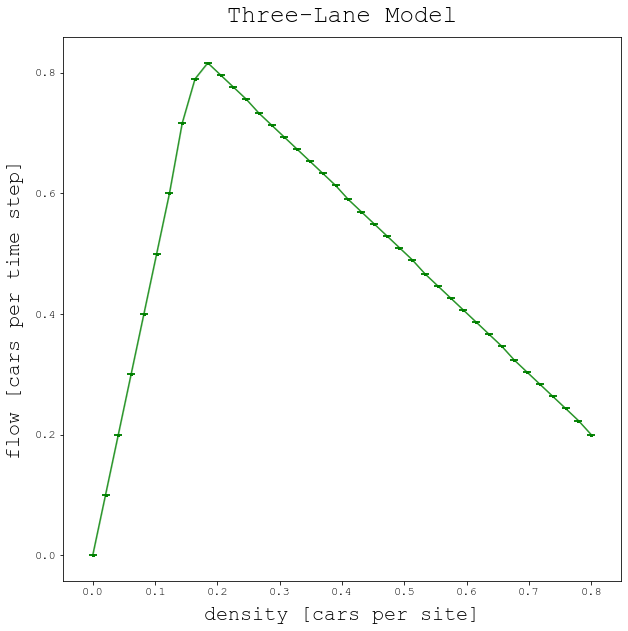

In [55]:
plot_data(data3det, title = "Three-Lane Model", color="Green")

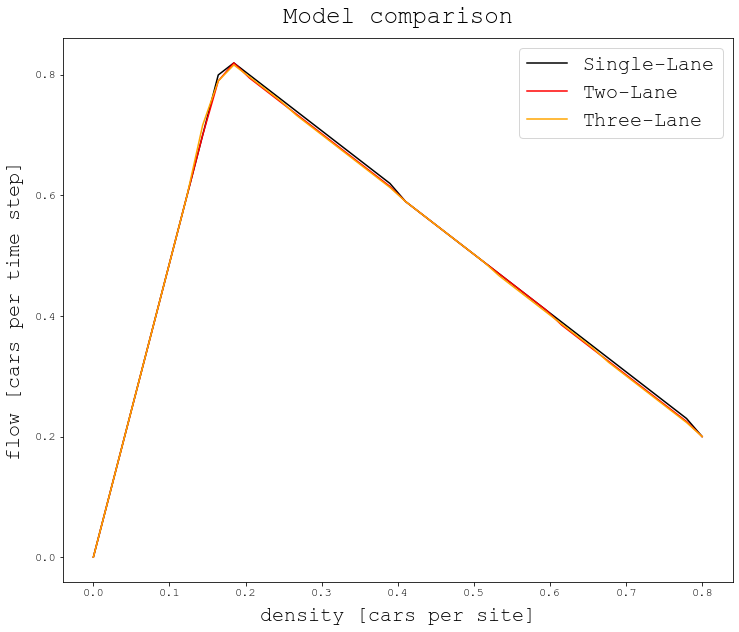

In [56]:
plot_multiple([data1det,data2det,data3det],labels = ["Single-Lane","Two-Lane","Three-Lane"], intervals = False)

In [35]:
data1long = collect_data(30,50,(0,0.8),700,0.5,1,700)

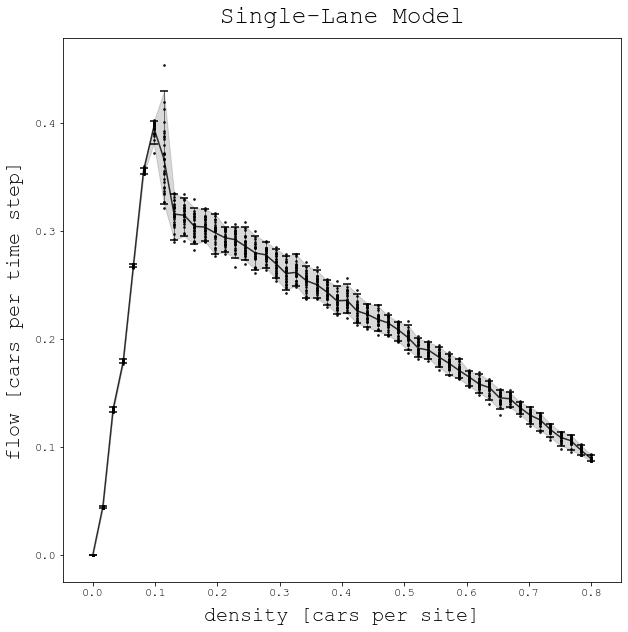

In [36]:
plot_data(data1long, title = "Single-Lane Model")

In [37]:
data2long = collect_data(30,50,(0,0.8),700,0.5,2,700)

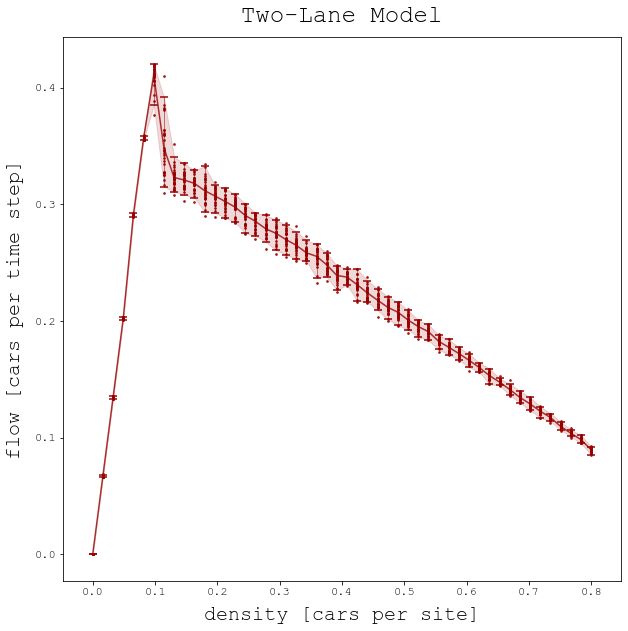

In [38]:
plot_data(data2long, title = "Two-Lane Model", color = "#990000")

In [39]:
data3long =  collect_data(30,50,(0,0.8),700,0.5,3,700,100,async_update=True)

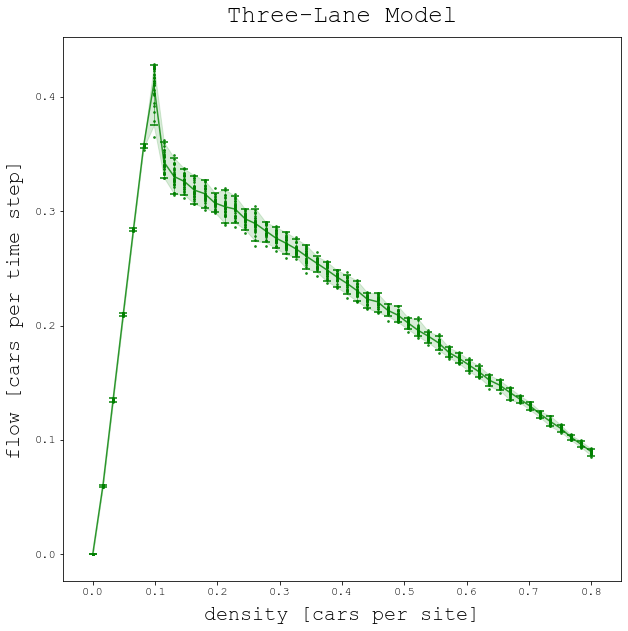

In [40]:
plot_data(data3long, title = "Three-Lane Model", color="Green")

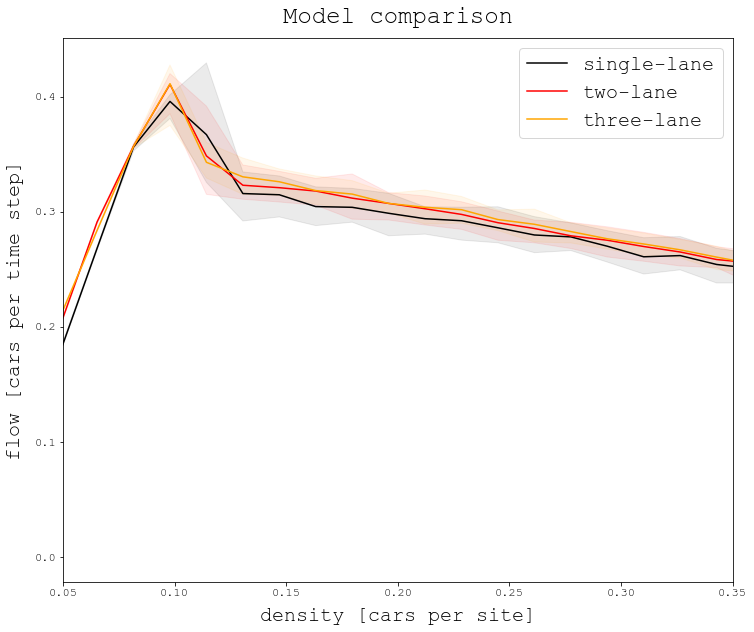

In [117]:
plot_multiple([data1long,data2long,data3long],['single-lane','two-lane','three-lane'],xlim = [0.05,0.35])